In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch
import torch.nn.functional as F

## Data Pre-processing

In [83]:
# Load the data
BitCoin = pd.read_csv('1_Bitcoin.csv')
BitCoin=BitCoin.applymap(lambda x: x.replace('$',''))
BitCoin=BitCoin.applymap(lambda x: x.replace(',',''))
cl = ['Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']
for c in cl:
    BitCoin[c] = BitCoin[c].astype(float)
MarketData = pd.read_excel('MarketData.xlsx') 
BitCoin['SP500'] = MarketData['S&P_processed'].values

BitCoin = BitCoin.rename(columns={'Open*': 'Open', 'Close**': 'Close'})
data_l = len(BitCoin)
BitCoin = BitCoin[data_l::-1]

In [84]:
BitCoin.head(5)

,Date,Open,High,Low,Close,Volume,Market Cap,SP500
3041,Jul 02 2013,88.05,92.30,87.51,90.13,0.0,1.024082e+09,4605.38
3040,Jul 03 2013,90.40,90.98,76.98,77.53,0.0,8.812331e+08,4596.42
3039,Jul 04 2013,78.89,83.11,72.00,80.53,0.0,9.156186e+08,4551.68
3038,Jul 05 2013,79.99,80.00,65.53,68.43,0.0,7.784112e+08,4574.79
3037,Jul 06 2013,68.50,75.00,66.82,70.28,0.0,7.997416e+08,4566.48


In [86]:
BitCoin.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap',
       'SP500'],
      dtype='object')

In [87]:
Data = BitCoin[['Close','Open','High', 'Low', 'Volume']]
in_dim = len(Data.columns)
# Time series length
time_stamp = 5

# Seperate training, validating, testing dataset
P = BitCoin[['Close','Open','High', 'Low', 'Volume']]
split_1 = int(len(Data) * 0.6)
split_2 = int(len(Data) *0.8)

train = Data[0:split_1+time_stamp]
valid = Data[split_1:split_2 + time_stamp]
test = Data[split_2 :]


In [88]:
# Normalization
scaler = MinMaxScaler()
def data_processing(data, time_stamp):
    min_ = data['Close'].min()
    max_ = data['Close'].max()
    scaled_data = scaler.fit_transform(data)
    x, y = [], []
    for i in range(time_stamp, len(data)-time_stamp):
        x.append(scaled_data[i-time_stamp:i,:])
        y.append(scaled_data[i,0])
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], in_dim))
    return x,y,max_,min_

x_train, y_train, max_train, min_train = data_processing(train, time_stamp)
x_valid, y_valid,max_valid, min_valid  = data_processing(valid, time_stamp)
x_test, y_test,max_test, min_test   = data_processing(test, time_stamp)

(1820, 5, 5)
(1820,)
(603, 5, 5)
(603,)
(599, 5, 5)
(599,)


In [89]:
# Build function to make dataset for pytorch
class PriceDataset(Dataset):
    def __init__(self,x_train,y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    def __len__(self):
        return len(x_train)
    
    def __getitem__(self, index):
        return x_train[index], y_train[index]

def makeloader(dataset,batch_size):
    
    loader = DataLoader(dataset, batch_size, shuffle = True)
    return loader

In [90]:
# Make dataset
batch_size = 64

dataset =  PriceDataset(x_train, y_train)
loader = makeloader(dataset, batch_size)

val_dataset =  PriceDataset(x_valid, y_valid)
val_loader = makeloader(val_dataset, batch_size)

test_dataset =  PriceDataset(x_test, y_test)
test_loader = makeloader(test_dataset, batch_size)


# TESTING
for batch_x, batch_y in loader:
    print(batch_x[0][0])
    print(batch_y.shape)
    break
    
dataset.x_train.shape

tensor([0.0195, 0.0198, 0.0190, 0.0202, 0.0014], dtype=torch.float64)
torch.Size([64])


(1820, 5, 5)

## Model

In [91]:
# Building LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim,hidden_dim,out_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim)
        self.lstm4 = nn.LSTM(hidden_dim, out_dim)
    def forward(self, x_train):        
        lstm_out1, _ = self.lstm1(x_train)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out3, _ = self.lstm3(lstm_out2)
        lstm_out, _ = self.lstm4(lstm_out3)
        return lstm_out

In [112]:
model=LSTM(in_dim,64,1)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
# loss function - MAPE,  is defined in traning process
print(model)

LSTM(
  (lstm1): LSTM(5, 64)
  (lstm2): LSTM(64, 64)
  (lstm3): LSTM(64, 64)
  (lstm4): LSTM(64, 1)
)


In [94]:
epoch = 200

# Initialize 2 lists for storing MAPE loss
Train_MAPE_list = np.zeros(epoch)
Valid_MAPE_list = np.zeros(epoch)
best_model = 0
lowest_valid =  float('inf') 

for epoch in range(epoch): 
    
       #     ====== TRAIN  ====== #
    model.train()
    total_loss = []
    for batch_x, batch_y in loader:
        model.zero_grad() # Clear them out Pytorch accumulated gradients before each instance
        out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1) # Run forward pass.
        # loss = loss_function(out, batch_y.float())       
        loss =abs (((out - batch_y.float())*(max_train - min_train))/(batch_y.float()*(max_train - min_train)+min_train))
        loss = torch.mean(loss)
#         print(loss.shape)
        loss.backward()
        optimizer.step()
        total_loss.append(loss)
    Train_MAPE = sum(total_loss)/len(total_loss)

    #     ====== VALID  ====== 
    model.eval()
    total_loss = []
    for batch_x, batch_y in val_loader:
            model.zero_grad()
            out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1)
#             loss = loss_function(out, batch_y.float())
            loss =abs (((out - batch_y.float())*(max_valid- min_valid))/((batch_y.float()*(max_valid - min_valid)+min_valid)))
            loss = torch.mean(loss)
            total_loss.append(loss)
    Valid_MAPE=sum(total_loss)/len(total_loss)
    
    print("Iter %d ,Train MAPE: %.5f, Valid MAPE: %.5f"%(epoch+1 ,Train_MAPE, Valid_MAPE))
    Train_MAPE_list[epoch] = Train_MAPE
    Valid_MAPE_list[epoch] = Valid_MAPE

<ipython-input-94-cb49ca05c1d1>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1) # Run forward pass.
<ipython-input-94-cb49ca05c1d1>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(batch_x).float())[:,-1,:].reshape(-1)


Iter 1 ,Train MAPE: 0.86825, Valid MAPE: 0.12886
Iter 2 ,Train MAPE: 0.59775, Valid MAPE: 0.13676
Iter 3 ,Train MAPE: 0.58879, Valid MAPE: 0.13590
Iter 4 ,Train MAPE: 0.58800, Valid MAPE: 0.13593
Iter 5 ,Train MAPE: 0.58811, Valid MAPE: 0.13169
Iter 6 ,Train MAPE: 0.59114, Valid MAPE: 0.13394
Iter 7 ,Train MAPE: 0.58963, Valid MAPE: 0.13544
Iter 8 ,Train MAPE: 0.58829, Valid MAPE: 0.13627
Iter 9 ,Train MAPE: 0.59071, Valid MAPE: 0.13379
Iter 10 ,Train MAPE: 0.58956, Valid MAPE: 0.13325
Iter 11 ,Train MAPE: 0.59095, Valid MAPE: 0.13397
Iter 12 ,Train MAPE: 0.58537, Valid MAPE: 0.13569
Iter 13 ,Train MAPE: 0.58815, Valid MAPE: 0.13043
Iter 14 ,Train MAPE: 0.58912, Valid MAPE: 0.13363
Iter 15 ,Train MAPE: 0.58503, Valid MAPE: 0.13149
Iter 16 ,Train MAPE: 0.57962, Valid MAPE: 0.12838
Iter 17 ,Train MAPE: 0.45500, Valid MAPE: 0.04184
Iter 18 ,Train MAPE: 0.27121, Valid MAPE: 0.03466
Iter 19 ,Train MAPE: 0.22938, Valid MAPE: 0.02021
Iter 20 ,Train MAPE: 0.14172, Valid MAPE: 0.01627
Iter 21 ,

Iter 164 ,Train MAPE: 0.03695, Valid MAPE: 0.00792
Iter 165 ,Train MAPE: 0.04002, Valid MAPE: 0.00710
Iter 166 ,Train MAPE: 0.03779, Valid MAPE: 0.00788
Iter 167 ,Train MAPE: 0.04043, Valid MAPE: 0.00748
Iter 168 ,Train MAPE: 0.04062, Valid MAPE: 0.00845
Iter 169 ,Train MAPE: 0.04161, Valid MAPE: 0.00662
Iter 170 ,Train MAPE: 0.03964, Valid MAPE: 0.00737
Iter 171 ,Train MAPE: 0.03963, Valid MAPE: 0.00732
Iter 172 ,Train MAPE: 0.04160, Valid MAPE: 0.00779
Iter 173 ,Train MAPE: 0.03822, Valid MAPE: 0.00909
Iter 174 ,Train MAPE: 0.03908, Valid MAPE: 0.00940
Iter 175 ,Train MAPE: 0.04566, Valid MAPE: 0.00841
Iter 176 ,Train MAPE: 0.04275, Valid MAPE: 0.00819
Iter 177 ,Train MAPE: 0.04497, Valid MAPE: 0.00759
Iter 178 ,Train MAPE: 0.04394, Valid MAPE: 0.00704
Iter 179 ,Train MAPE: 0.04225, Valid MAPE: 0.00724
Iter 180 ,Train MAPE: 0.04174, Valid MAPE: 0.00760
Iter 181 ,Train MAPE: 0.03905, Valid MAPE: 0.00744
Iter 182 ,Train MAPE: 0.04528, Valid MAPE: 0.00963
Iter 183 ,Train MAPE: 0.03949, 

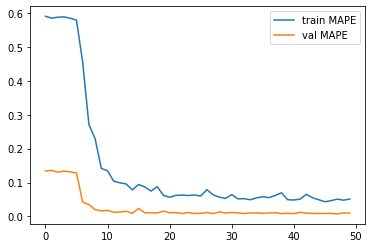

In [100]:
x_axis = np.arange(50)
plt.plot(x_axis, Train_MAPE_list[10:60], label='train MAPE')
plt.plot(x_axis, Valid_MAPE_list[10:60], label='val MAPE')
plt.legend()
plt.show()

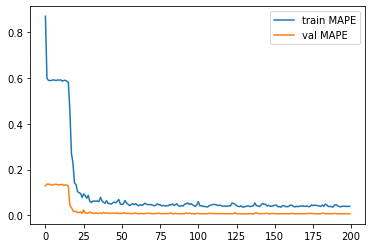

In [101]:
x_axis = np.arange(epoch+1)
plt.plot(x_axis, Train_MAPE_list[:], label='train MAPE')
plt.plot(x_axis, Valid_MAPE_list[:], label='val MAPE')
plt.legend()
plt.show()

## Test & Report Data

In [106]:
## test performance on the test set and report final performance
X_test_tensor =  torch.tensor(x_test).float()
y_test_pred = model(X_test_tensor).float()[:,-1,:].reshape(-1).detach().numpy()
y_test_pred_inverse = y_test_pred*(max_test - min_test)+min_test
y_test_invesre = y_test*(max_test - min_test)+min_test

test_MAPE=sum(abs ((y_test_invesre - y_test_pred_inverse)/y_test_invesre))/len(y_test_invesre)
print("The mean absolute percentage error for the LSTM is: %2f"%test_MAPE)


shape of test_y_pred:    (599,)
The mean absolute percentage error for the LSTM is: 0.040828


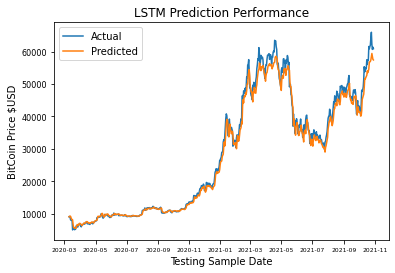

In [121]:
date = np.array(BitCoin[2443:]['Date'])
x_axis = date
plt.plot(x_axis, y_test_invesre, label='Actual')
plt.plot(x_axis, y_test_pred_inverse, label='Predicted')
plt.tick_params(axis = 'x', labelsize = 6)
plt.tick_params(axis = 'y', labelsize = 8)
plt.xlabel('Testing Sample Date')
plt.ylabel('BitCoin Price $USD')
plt.title("LSTM Prediction Performance")
plt.legend()
plt.show()

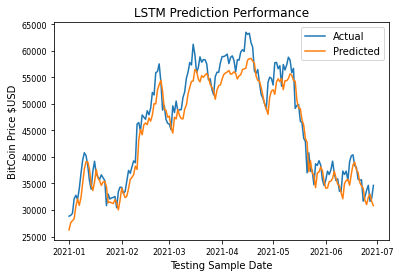

In [119]:
BitCoin['Date']=pd.to_datetime(BitCoin['Date'])
date = np.array(BitCoin[2740:2920]['Date'])
x_axis = date
plt.plot(x_axis, y_test_invesre[300:480], label='Actual')
plt.plot(x_axis, y_test_pred_inverse[300:480], label='Predicted')
plt.tick_params(axis = 'x', labelsize = 8)
plt.tick_params(axis = 'y', labelsize = 8)
plt.xlabel('Testing Sample Date')
plt.ylabel('BitCoin Price $USD')
plt.title("LSTM Prediction Performance")
plt.legend()
plt.show()